
CNN feature extraction from satellite images using pretrained ResNet


In [1]:
import os
import pandas as pd

# paths
TRAIN_CSV = "../data/train.csv"
IMAGE_DIR = "../images/train"

# load data
train_df = pd.read_csv(TRAIN_CSV)
image_files = sorted(os.listdir(IMAGE_DIR))

print("Train rows:", train_df.shape[0])
print("Images:", len(image_files))
print("First 5 images:", image_files[:5])


Train rows: 16209
Images: 540
First 5 images: ['0.png', '1.png', '10.png', '100.png', '101.png']


(-0.5, 255.5, 255.5, -0.5)

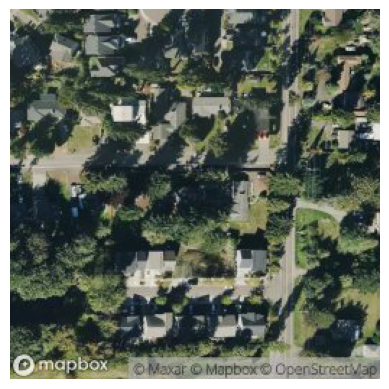

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "../images/train/0.png"
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")


In [3]:
import numpy as np
from PIL import Image
import os

IMG_DIR = "../images/train"
IMG_SIZE = (224, 224)

def load_images(img_dir, max_images=540):
    images = []
    ids = []

    for fname in sorted(os.listdir(img_dir))[:max_images]:
        img_id = int(fname.split(".")[0])
        img_path = os.path.join(img_dir, fname)

        img = Image.open(img_path).convert("RGB")
        img = img.resize(IMG_SIZE)

        img_arr = np.array(img) / 255.0  # normalize
        images.append(img_arr)
        ids.append(img_id)

    return np.array(images), np.array(ids)

X_images, image_ids = load_images(IMG_DIR)

print(X_images.shape)
print(image_ids[:5])


(540, 224, 224, 3)
[  0   1  10 100 101]


In [4]:
import cv2
import numpy as np
import os
from PIL import Image

IMG_DIR = "../images/train"
IMG_SIZE = (224, 224)

def extract_hog_features(img_dir, max_images=540):
    features = []
    ids = []

    hog = cv2.HOGDescriptor(
        _winSize=(224,224),
        _blockSize=(32,32),
        _blockStride=(16,16),
        _cellSize=(16,16),
        _nbins=9
    )

    for fname in sorted(os.listdir(img_dir))[:max_images]:
        img_id = int(fname.split(".")[0])
        path = os.path.join(img_dir, fname)

        img = Image.open(path).convert("L")  # grayscale
        img = img.resize(IMG_SIZE)
        img = np.array(img)

        hog_feat = hog.compute(img).flatten()

        features.append(hog_feat)
        ids.append(img_id)

    return np.array(features), np.array(ids)

hog_features, hog_ids = extract_hog_features(IMG_DIR)

print(hog_features.shape)
print(hog_ids[:5])


(540, 6084)
[  0   1  10 100 101]


In [6]:
print(hog_ids[:10])


[  0   1  10 100 101 102 103 104 105 106]


In [7]:
train_df = train_df.reset_index(drop=True)
train_df["row_id"] = train_df.index


In [8]:
img_feat_df = pd.DataFrame(hog_features)
img_feat_df["row_id"] = hog_ids

train_merged = train_df.merge(img_feat_df, on="row_id", how="inner")

print("Merged shape:", train_merged.shape)
train_merged.head()


Merged shape: (540, 6106)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,6074,6075,6076,6077,6078,6079,6080,6081,6082,6083
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,0.133807,0.159925,0.223896,0.180471,0.155369,0.223896,0.178566,0.118236,0.143399,0.127185
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,0.149279,0.140249,0.161953,0.146207,0.150855,0.215745,0.215745,0.152367,0.156880,0.160450
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,0.213506,0.127198,0.136360,0.197615,0.213506,0.213506,0.213506,0.139325,0.161952,0.156625
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,0.087514,0.099335,0.081651,0.101566,0.145914,0.221086,0.207489,0.139555,0.143714,0.100806
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,0.204343,0.132585,0.139483,0.135982,0.121139,0.203120,0.204343,0.169294,0.161947,0.190372


In [9]:
print("Rows:", train_merged.shape[0])
print("Columns:", train_merged.shape[1])

print("\nColumns sample:")
print(train_merged.columns[:10])

print("\nLast 10 columns (should be image features):")
print(train_merged.columns[-10:])

print("\nAny NaNs?")
print(train_merged.isna().sum().sum())

print("\nPrice stats:")
print(train_merged["price"].describe())


Rows: 540
Columns: 6106

Columns sample:
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view'],
      dtype='object')

Last 10 columns (should be image features):
Index([6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083], dtype='object')

Any NaNs?
0

Price stats:
count    5.400000e+02
mean     5.172117e+05
std      2.994098e+05
min      8.500000e+04
25%      3.150000e+05
50%      4.450000e+05
75%      6.360000e+05
max      2.535000e+06
Name: price, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. Separate features & target
X_tab = train_merged[
    ['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
     'waterfront','view','condition','grade','sqft_above',
     'sqft_basement','yr_built','yr_renovated','zipcode',
     'lat','long','sqft_living15','sqft_lot15']
]

y = train_merged['price']

# 2. Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)

# 3. Model
model_tab = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model_tab.fit(X_train, y_train)

# 4. Evaluate
preds = model_tab.predict(X_val)

print("MAE:", mean_absolute_error(y_val, preds))
print("RMSE:", mean_squared_error(y_val, preds, squared=False))
print("R2:", r2_score(y_val, preds))


MAE: 95900.10104938272
RMSE: 168732.19616819816
R2: 0.7215192500474437


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)


In [16]:
model_mm = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

model_mm.fit(X_train, y_train)

preds = model_mm.predict(X_val)

print("MAE:", mean_absolute_error(y_val, preds))
print("RMSE:", mean_squared_error(y_val, preds, squared=False))
print("R2:", r2_score(y_val, preds))


MAE: 128968.00821759259
RMSE: 194888.77245807933
R2: 0.6284879525370266


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import pandas as pd

df = X_full.copy()
df['price'] = y


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Split columns
img_cols = [c for c in df.columns if str(c).isdigit()]
tab_cols = [c for c in df.columns if c not in img_cols + ['price']]

X_tab = df[tab_cols]
X_img = df[img_cols]
y = df['price']

# Scale image features
scaler = StandardScaler()
X_img_scaled = scaler.fit_transform(X_img)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_img_pca = pca.fit_transform(X_img_scaled)

print("PCA components:", X_img_pca.shape[1])

# Combine
import numpy as np
X_final = np.hstack([X_tab.values, X_img_pca])


PCA components: 429


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train model
model_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model_final.fit(X_train, y_train)

preds = model_final.predict(X_val)

print("MAE:", mean_absolute_error(y_val, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_val, preds)))
print("R2:", r2_score(y_val, preds))


MAE: 128634.97150860187
RMSE: 195997.54684467867
R2: 0.6242486645826937


In [21]:
X_tab_only = df[tab_cols]  # no image features

X_train, X_val, y_train, y_val = train_test_split(
    X_tab_only, y, test_size=0.2, random_state=42
)

model_tab = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model_tab.fit(X_train, y_train)
preds = model_tab.predict(X_val)

print("MAE:", mean_absolute_error(y_val, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_val, preds)))
print("R2:", r2_score(y_val, preds))


MAE: 97759.67125601896
RMSE: 166915.9542909097
R2: 0.7274821456366827


In [22]:
from sklearn.linear_model import LinearRegression

X_tab_only = df[tab_cols]

X_train, X_val, y_train, y_val = train_test_split(
    X_tab_only, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_val)

print("Linear MAE:", mean_absolute_error(y_val, preds))
print("Linear RMSE:", np.sqrt(mean_squared_error(y_val, preds)))
print("Linear R2:", r2_score(y_val, preds))


Linear MAE: 110554.81456578727
Linear RMSE: 149939.73413558627
Linear R2: 0.7800961999119971
